<h1>Using ICASAR to correct time series of volcanic deformation.  </h1>

We can consider time series of deformation at a volcano as linear mixtures of several latent (hidden/unobservable) sources, such as deformation or a topographically correlated atmospheric phase screen.  Independent component analysis (ICA) is a powerful tool to recover these latent sources, and the ICASAR package is designed to do this with InSAR time series.  

We'll import the ICASAR package to do this, but we'll also import the LiCSAlert function as it has a handy tool for downsampling data and keeping things fast.  


In [1]:
# -*- coding: utf-8 -*-
"""
An example of the ICASAR software with real data from LiCSBAS that contains a deformation signals that is not visible in a single 6/12 days Sentinel-1 interferogram.  
"""

import numpy as np
import matplotlib.pyplot as plt   
import pickle
from pathlib import Path
import sys

sys.path.append("./ICASAR-2.7.3")
sys.path.append("./LiCSAlert-2.1.3")

import icasar
from icasar.icasar_funcs import ICASAR, LiCSBAS_to_ICASAR
from icasar.aux import visualise_ICASAR_inversion

import licsalert
from licsalert.licsalert import LiCSAlert_preprocessing

from supporting_functions import matrix_show, col_to_ma, r2_to_r3, plot_points_interest, plot_points_on_image




Bad key savefig.frameon in file /home/matthew/anaconda3/envs/ICASAR_jupyter/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/matthew/anaconda3/envs/ICASAR_jupyter/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/matthew/anaconda3/envs/ICASAR_jupyter/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log fi

In this cell, we can set some settings. Unfortunately, ICASAR needs ~8GB of RAM to run and binder is limited to 2GB, so we won't be able to change the ICASAR_settings in this session.  


In [2]:
############ Editable: This are the points were interested in the deformation of.  
points_interest = {'deforming' : (102, 80),                 # These are points chosen at interest from the LICSBAS data.  x then y!
                    'highlands' : (161, 31)}                    # Note, these are set when downsampling is 1, and will be automatically adjusted it downsample is adjusted.  
############ end




ICASAR_settings = {"n_comp" : 5,                                         # number of components to recover with ICA (ie the number of PCA sources to keep)
                   "bootstrapping_param" : (200, 0),                    # (number of runs with bootstrapping, number of runs without bootstrapping)                    "hdbscan_param" : (35, 10),                        # (min_cluster_size, min_samples)
                   "tsne_param" : (30, 12),                             # (perplexity, early_exaggeration)
                   "ica_param" : (1e-2, 150),                           # (tolerance, max iterations)
                   "hdbscan_param" : (100,10),                           # (min_cluster_size, min_samples) Discussed in more detail in Mcinnes et al. (2017). min_cluster_size sets the smallest collection of points that can be considered a cluster. min_samples sets how conservative the clustering is. With larger values, more points will be considered noise. 
                   "out_folder" : Path('insar_workshop_example'),   # outputs will be saved here
                   "create_all_ifgs_flag" : True,                       # small signals are hard for ICA to extact from time series, so make it easier by creating all possible long temporal baseline ifgs from the incremental data.  
                   "load_fastICA_results" : True,                      # If all the FastICA runs already exisit, setting this to True speeds up ICASAR as they don't need to be recomputed.  
                   "figures" : "png+window"}                            # if png, saved in a folder as .png.  If window, open as interactive matplotlib figures,
                                                                         # if 'png+window', both.  
                                                                         # default is "window" as 03_clustering_and_manifold is interactive.  
                                                                    
LiCSBAS_out_folder_campi_flegrei = Path("./124D_04854_171313_licsbas_example_extended_rationalized")
downsample = 0.7                           # 0.7 creates a FastICA file that is just under 100MB and therefore fine to use with GitHub.  



LiCSBAS provides a simple and powerful way to create time series of LiCSAR interferograms.  Opening the outputs for use with ICASAR is simple, and returns the intererograms both as 2d arrays (in displacement_r3) and as 1d arrays (i.e. row or column vectors, in dislacement_r2).

We can also extract the refence pixel used by LiCSBAS and add it to our points_interest dictionary.  

Activity 1: Can you use the matrix_show function to explore the other LiCSBAS outputs.  Do the lons and lats values looks reasonable?  What are E, N and U?  Why is there one more acq_date than ifg_dates?  

Opening the LiCSBAS .h5 file...cumulative : (158, 121, 191)
incremental : (157, 121, 191)
lons : (121, 191)
lats : (121, 191)
dem : (121, 191)
E : (121, 191)
N : (121, 191)
U : (121, 191)

cumulative : (158, 13723)
mask : (121, 191)
incremental : (157, 13723)
lons : (121, 191)
lats : (121, 191)
dem : (121, 191)
E : (121, 191)
N : (121, 191)
U : (121, 191)

acq_dates : 158
ifg_dates : 157
baselines : 157
baselines_cumulative : 157


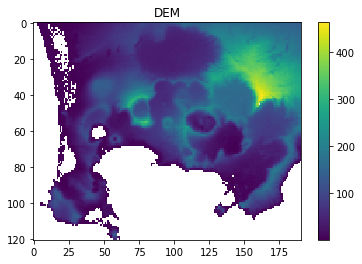

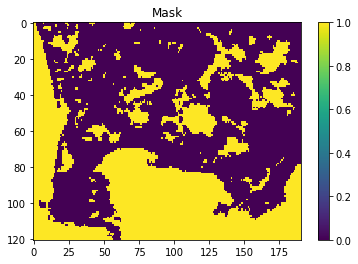

In [3]:
print(f"Opening the LiCSBAS .h5 file...", end = '')
displacement_r3, displacement_r2, tbaseline_info, ref_xy = LiCSBAS_to_ICASAR(LiCSBAS_out_folder_campi_flegrei, figures=True, ref_area = True, return_r3 = True)        # open various LiCSBAS products, spatial ones in displacement_r2, temporal ones in tbaseline_info

points_interest['reference'] = (int(np.mean([ref_xy['x_start'], ref_xy['x_stop']])),                                                # also get the reference pixel out
                                int(np.mean([ref_xy['y_start'], ref_xy['y_stop']])))

for key, variable in displacement_r3.items():
    print(f"{key} : {variable.shape}")
print()
for key, variable in displacement_r2.items():
    print(f"{key} : {variable.shape}")
print()
for key, variable in tbaseline_info.items():
    print(f"{key} : {len(variable)}")    

#%% Have a look at some parts of the LiCSBAS time series

# 1: The DEM.  
matrix_show(displacement_r2['dem'], title = 'DEM')

# 2: The mask.  
matrix_show(displacement_r2['mask'], title = 'Mask')




Some points_of_interest were defined in the first cell, and we can visualise these on the different LiCSBAS data.  

Activity 2: Can you improve the position of the points?  Does "deforming"  lie on the region with the highest deformation?  Does the "highlands" one lie on the highest topograhy pixel?  

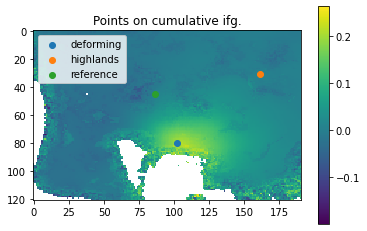

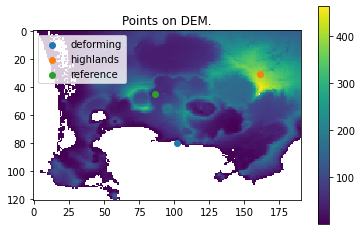

In [4]:
########## editable
points_interest['deforming'] = (102, 80)                 # 
points_interest['highlands'] = (161, 31)                    # 
########## editable


plot_points_on_image(np.sum(displacement_r3['incremental'], axis = 0), 
                     points_interest, title = 'Points on cumulative ifg.')

plot_points_on_image(displacement_r2['dem'], 
                     points_interest, title = 'Points on DEM.')


To speed things up, we can downsample our data slightly.  As we have defined out pixels of interest using pixel number (i.e. they are not latitudes and longitudes), we will also have to change their position to refelct the new resoluiton.  

When we inspect the sizes of the arrays, have they changed?  

 

In [5]:
del displacement_r2['cumulative']                       # remove a few things we don't want to downsample
del displacement_r3                                     # rather than downsample twice, we can delete this data form the rank 3 bit


displacement_r2 = LiCSAlert_preprocessing(displacement_r2, downsample, 1.0, mean_centre = False)                                                                # mean centre and downsample

for key, value in points_interest.items():                                                                                      # also change the points of interest (which are affected by downsampling)
    points_interest[key] = (int(value[0] * downsample), int(value[1] * downsample))

for key, variable in displacement_r2.items():
    print(f"{key} : {variable.shape}")
print()
for key, variable in tbaseline_info.items():
    print(f"{key} : {len(variable)}")    

Interferogram were originally (121, 191) (13723 unmasked pixels), but have been downsampled to (85, 134) (6769 unmasked pixels) for use with LiCSAlert, and have been downsampled to (85, 134) (6769 unmasked pixels) for figures.  
mask : (85, 134)
incremental : (157, 6769)
lons : (85, 134)
lats : (85, 134)
dem : (85, 134)
E : (85, 134)
N : (85, 134)
U : (85, 134)
incremental_downsampled : (157, 6769)
mask_downsampled : (85, 134)

acq_dates : 158
ifg_dates : 157
baselines : 157
baselines_cumulative : 157


We can now plot the time series for our points of interest.  Note, before we do that, we'll remake the rank 3 data (incremental_r3) from the downsampled rank 2 data.  

Activity 3: Look at the shapes of the arrays in displacement_r2 vs incremental_r3.  Is the difference between them clear?  

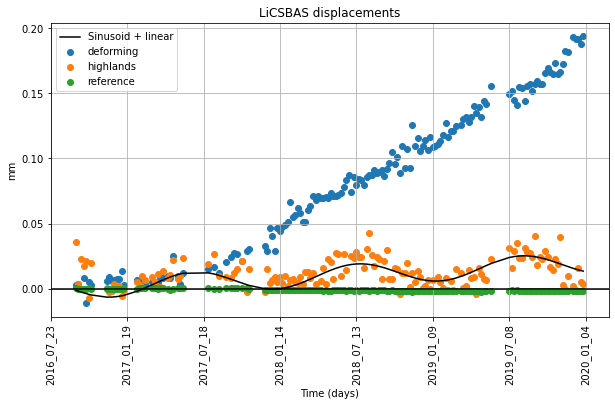

In [6]:
#%% Plot the time series for a few points at different elevations.  
incremental_r3 = r2_to_r3(displacement_r2['incremental'], displacement_r2['mask'])                                          # convert rank 2 (ie row vectors) to rank 3 (e.g n_images x ny x nx)

plot_points_interest(incremental_r3, points_interest, tbaseline_info['baselines_cumulative'], tbaseline_info['acq_dates'], 'LiCSBAS displacements', 'mm')



ICA (via the ICASAR algorithm) is quite RAM heavy (~8GB in this example) so won't run on Binder.  We can loads results that were computer on a different machine, and you can always try to adjust these settings yourself. 

We can also show the results from the local run.

First, for PCA:
![](./insar_workshop_example/03_PCA_source_correlations.png)

Second, for ICA:

![](./insar_workshop_example/06_ICA_source_correlations.png)

Activity 4: What signal/process do you think IC0 captures?  What signal/process do you think IC2 captures?  How do the ICA results compare to the PCA results (hint: what do PCs 1,2 and 3 correlate with?).  



In [7]:
#%% do ICA with ICSAR function

ifg_means = np.mean(incremental_r3, axis = (1,2))[:, np.newaxis, np.newaxis]                                                        # get the mean for each ifg

#spatial_data = {'mixtures_r2'    : displacement_r2['incremental'],
#                'mask'           : displacement_r2['mask'],
#                'ifg_dates'      : tbaseline_info['ifg_dates'],                             # this is optional.  In the previous example, we didn't have it, in form YYYYMMDD_YYYYMMDD as a list of strings.  
#                'dem'            : displacement_r2['dem'],                                  # this is optional.  In the previous example, we didn't have it
#                'lons'           : displacement_r2['lons'],
#                'lats'           : displacement_r2['lats']}
                

#ics, tcs, x_train_residual_ts, Iq, n_clusters, S_all_info, phUnw_mean  = ICASAR(spatial_data = spatial_data, **ICASAR_settings) 

#plt.pause(1)               # force figures to show.  


with open(Path("./insar_workshop_example") / "ICASAR_results.pkl", 'rb') as f:
    ics = pickle.load(f)    
    mask = pickle.load(f)    
    tcs  = pickle.load(f)    
    source_residuals = pickle.load(f)    
    Iq_sorted = pickle.load(f)    
    n_clusters = pickle.load(f)
    
#plt.pause(1)               # force figures to show.  


We can now recreate our time series using only the ICs we deem important.  I've started by using all of them.  How well does this compare with the original time series?  

Activity 5: Can you select only some of the ICs to reconstruct the time series without any topograhpically correlated phase screens?  



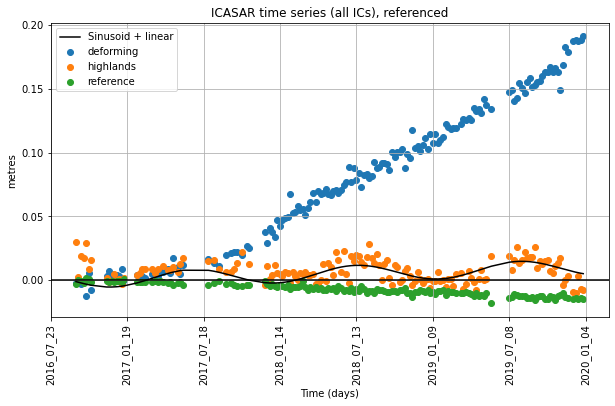

In [11]:
#%% Plot the time series for the same points, using ICASAR correction.  
######## editable
incremental_r2_mc_hat = tcs[:,0:5] @ ics[0:5, :]                                                                                               # reconstruct using the ICs.  
######### end 
incremental_r3_mc_hat = r2_to_r3(incremental_r2_mc_hat, displacement_r2['mask'])                                                     # convert rank 2 (ie row vectors) to rank 3 (e.g n_images x ny x nx)

incremental_r3_hat = incremental_r3_mc_hat + np.repeat(np.repeat(ifg_means, incremental_r3.shape[1], 1), incremental_r3.shape[2], 2)
plot_points_interest(incremental_r3_mc_hat, points_interest, tbaseline_info['baselines_cumulative'], tbaseline_info['acq_dates'], 'ICASAR time series (all ICs), referenced',  'metres')##
